# Gluon interface example for `fred_md`

This notebook contains an example of training the TACTiS model on the `fred_md` dataset, using arbitrary hyperparameters as in the paper and a reduced training time.

In [24]:
# Install tactis if you haven't installed yet
!pip install tactis[research]

In [6]:
import torch
from tactis.gluon.estimator import TACTiSEstimator
from tactis.gluon.trainer import TACTISTrainer
from tactis.gluon.dataset import generate_hp_search_datasets, generate_prebacktesting_datasets, generate_backtesting_datasets
from tactis.gluon.metrics import compute_validation_metrics
from tactis.gluon.plots import plot_four_forecasts
from gluonts.evaluation.backtest import make_evaluation_predictions

/home/toolkit/.conda/envs/tactis/lib/python3.10/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


## Loading the dataset

This loads the dataset as it was used during the **hyperparameter search experiments**.

If you're interested in the backtesting experiments, you can scroll down to **Loading and training with the backtesting dataset**.

In [8]:
history_factor = 1

metadata, train_data, valid_data = generate_hp_search_datasets("fred_md", history_factor)

## Creating the GluonTS Estimator object

The following hyperparameters (together with the history factor of 1) are those used in our benchmark for `fred_md`, although with a reduced training time since we took a limit of 3 days for our benchmark.

In [9]:
estimator = TACTiSEstimator(
    model_parameters = {
        "flow_series_embedding_dim": 5,
        "copula_series_embedding_dim": 5,
        "flow_input_encoder_layers": 2,
        "copula_input_encoder_layers": 2,
        "input_encoding_normalization": True,
        "data_normalization": "standardization",
        "loss_normalization": "series",
        "bagging_size": 20,
        "positional_encoding":{
            "dropout": 0.0,
        },
        "flow_temporal_encoder":{
            "attention_layers": 2,
            "attention_heads": 1,
            "attention_dim": 16,
            "attention_feedforward_dim": 16,
            "dropout": 0.0,
        },
        "copula_temporal_encoder":{
            "attention_layers": 2,
            "attention_heads": 1,
            "attention_dim": 16,
            "attention_feedforward_dim": 16,
            "dropout": 0.0,
        },
        "copula_decoder":{
            "min_u": 0.05,
            "max_u": 0.95,
            "attentional_copula": {
                "attention_heads": 3,
                "attention_layers": 1,
                "attention_dim": 8,
                "mlp_layers": 2,
                "mlp_dim": 48,
                "resolution": 20,
                "activation_function": "relu"
            },
            "dsf_marginal": {
                "mlp_layers": 2,
                "mlp_dim": 48,
                "flow_layers": 2,
                "flow_hid_dim": 8,
            },
        },
    },
    num_series = train_data.list_data[0]["target"].shape[0],
    history_length = history_factor * metadata.prediction_length,
    prediction_length = metadata.prediction_length,
    freq = metadata.freq,
    trainer = TACTISTrainer(
        epochs_phase_1 = 20,
        epochs_phase_2 = 20,
        batch_size = 256,
        num_batches_per_epoch = 512,
        learning_rate = 1e-3,
        weight_decay = 1e-4,
        maximum_learning_rate = 1e-3,
        clip_gradient = 1e3,
        device = torch.device("cuda:3"),
    ),
    cdf_normalization = False,
    num_parallel_samples = 100,
)

Checkpoints will not be saved


## The training

In [10]:
model = estimator.train(train_data, valid_data)

Start epoch: 0
Total epochs: 100
Epochs: 100
Flow loss weight: 1.0
Copula loss weight: 0.0
Epoch: 0 / 100
Training...
Total number of training batches: 50


/home/toolkit/.conda/envs/tactis/lib/python3.10/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)


Epoch: 0 Average training loss: 347563.8125
Validation...
Creating a validation dataloader with a batch size of 256
Epoch: 0 Average validation loss: 34.200843811035156
Epochs since best epoch: 0
Epoch: 1 / 100
Training...
Total number of training batches: 50
Epoch: 1 Average training loss: 241.30690002441406
Validation...
Creating a validation dataloader with a batch size of 256
Epoch: 1 Average validation loss: 34.095420837402344
Epochs since best epoch: 0
Epoch: 2 / 100
Training...
Total number of training batches: 50
Epoch: 2 Average training loss: 31.978239059448242
Validation...
Creating a validation dataloader with a batch size of 256
Epoch: 2 Average validation loss: 33.39619064331055
Epochs since best epoch: 0
Epoch: 3 / 100
Training...
Total number of training batches: 50
Epoch: 3 Average training loss: 31.95073890686035
Validation...
Creating a validation dataloader with a batch size of 256
Epoch: 3 Average validation loss: 33.618412017822266
Epochs since best epoch: 1
Epoch

Epoch: 20 Average training loss: -0.022313686087727547
Validation...
Creating a validation dataloader with a batch size of 256
Epoch: 20 Average validation loss: 0.08083536475896835
Epochs since best epoch: 0
Epoch: 21 / 100
Training...
Total number of training batches: 50
Epoch: 21 Average training loss: -0.0656304731965065
Validation...
Creating a validation dataloader with a batch size of 256
Epoch: 21 Average validation loss: -0.05600224435329437
Epochs since best epoch: 1
Epoch: 22 / 100
Training...
Total number of training batches: 50
Epoch: 22 Average training loss: -0.17159488797187805
Validation...
Creating a validation dataloader with a batch size of 256
Epoch: 22 Average validation loss: -0.26316800713539124
Epochs since best epoch: 0
Epoch: 23 / 100
Training...
Total number of training batches: 50
Epoch: 23 Average training loss: -0.8650323152542114
Validation...
Creating a validation dataloader with a batch size of 256
Epoch: 23 Average validation loss: -1.466025710105896


If you wish to perform hyperparameter search, you can use the best validation loss you obtain from above (with early stopping) as the result for a specific trial of hyperparameter search.

Note that in TACTiS-2, the hyperparameter search is separately done for phase 1 (parameters corresponding to the marginal distribution) and phase 2 (parameters corresponding to the copula).

Once you obtain the optimal model parameters after hyperparameter search, you can train on each of the backtest sets as below on the train-val sets of each backtest set, and then evaluate on the test set of the respective backtest set.

## Loading and training with the backtesting dataset

Similar to how the dataset was loaded for the hyperparameter search, but we need to select a backtesting id.
Since our backtesting dataset has three parts - a training set, a validation set and a test set, training is done with the training and validation sets, and later we evaluate the model on the test set on which we report results on.

Below, we use an arbitrary backtest ID. In the paper, we report results averaged across all six backtest sets of a dataset (backtest_ids `0`, `1`, `2`, `3`, `4`, `5`).

In [11]:
backtest_id = 3
metadata, backtest_train_data, backtest_valid_data = generate_prebacktesting_datasets("fred_md", backtest_id, history_factor)
_, _, backtest_test_data = generate_backtesting_datasets("fred_md", backtest_id, history_factor)

/home/toolkit/.conda/envs/tactis/lib/python3.10/site-packages/gluonts/dataset/multivariate_grouper.py:177: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  freq=data[FieldName.START].freq,


In [12]:
model = estimator.train(backtest_train_data, backtest_valid_data)

Start epoch: 0
Total epochs: 100
Epochs: 100
Flow loss weight: 1.0
Copula loss weight: 0.0
Epoch: 0 / 100
Training...
Total number of training batches: 50
Epoch: 0 Average training loss: 215098.421875
Validation...
Creating a validation dataloader with a batch size of 256
Epoch: 0 Average validation loss: 32.45288848876953
Epochs since best epoch: 0
Epoch: 1 / 100
Training...
Total number of training batches: 50
Epoch: 1 Average training loss: 806.298583984375
Validation...
Creating a validation dataloader with a batch size of 256
Epoch: 1 Average validation loss: 33.54755783081055
Epochs since best epoch: 1
Epoch: 2 / 100
Training...
Total number of training batches: 50
Epoch: 2 Average training loss: 32.11142349243164
Validation...
Creating a validation dataloader with a batch size of 256
Epoch: 2 Average validation loss: 33.14421463012695
Epochs since best epoch: 2
Epoch: 3 / 100
Training...
Total number of training batches: 50
Epoch: 3 Average training loss: 32.366119384765625
Vali

Epoch: 20 Average training loss: -0.009603699669241905
Validation...
Creating a validation dataloader with a batch size of 256
Epoch: 20 Average validation loss: 0.26273229718208313
Epochs since best epoch: 1
Epoch: 21 / 100
Training...
Total number of training batches: 50
Epoch: 21 Average training loss: -0.033308323472738266
Validation...
Creating a validation dataloader with a batch size of 256
Epoch: 21 Average validation loss: 0.02511812560260296
Epochs since best epoch: 2
Epoch: 22 / 100
Training...
Total number of training batches: 50
Epoch: 22 Average training loss: -0.13155268132686615
Validation...
Creating a validation dataloader with a batch size of 256
Epoch: 22 Average validation loss: -0.48818013072013855
Epochs since best epoch: 3
Epoch: 23 / 100
Training...
Total number of training batches: 50
Epoch: 23 Average training loss: -0.44601306319236755
Validation...
Creating a validation dataloader with a batch size of 256
Epoch: 23 Average validation loss: -1.44720399379730

## Negative Log-Likelihood of the testing dataset

In [13]:
# Evaluate for NLL
nll = estimator.validate(backtest_test_data, backtesting=True)
print("NLL:", nll.item())

Validation...
Creating a validation dataloader with a batch size of 256
NLL: 31.747730255126953


## Metrics for the testing dataset

Measuring the metrics on the testing dataset. Note that we use `split=False` due to the testing dataset already being split into multiple timestamps.

We reduce the batch size since we generate many samples in parallel (see the `num_parallel_samples` parameter of the Estimator object), without using bagging. The extra memory usage is somewhat compensated by not having to keep gradient information, but not completely.

In [14]:
# Enable copula in the model_parameters since the copula is now trained
# This needs to be done again here since a 
# TACTiSPredictionNetwork is created for inference from the `model_parameters`
estimator.model_parameters["skip_copula"] = False

# Create predictor
transformation = estimator.create_transformation()
device = estimator.trainer.device
predictor = estimator.create_predictor(
    transformation=transformation,
    trained_network=model,
    device=device,
    experiment_mode="forecasting",
    history_length=history_factor * metadata.prediction_length,
)

In [15]:
predictor.batch_size = 16
metrics, ts_wise_metrics = compute_validation_metrics(
    predictor=predictor,
    dataset=backtest_test_data,
    window_length=estimator.history_length + estimator.prediction_length,
    prediction_length=estimator.prediction_length,
    num_samples=100,
    split=False,
)

Using batch size: 16


In [16]:
metrics

{'CRPS': 0.04888507351646156,
 'ND': 0.06024619223564207,
 'NRMSE': 0.6140004430857003,
 'MSE': 915282299.2808439,
 'CRPS-Sum': 0.046170125765578385,
 'ND-Sum': 0.056679645939703455,
 'NRMSE-Sum': 0.061549009538180315,
 'MSE-Sum': 105299771392.0,
 'num_nan': 0,
 'num_inf': 0}

## Plotting the forecasts

Plot the forecast for the last timestamp of the validation dataset.

In [17]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=backtest_test_data, predictor=predictor, num_samples=100
)
forecasts = list(forecast_it)
targets = list(ts_it)

/home/toolkit/.conda/envs/tactis/lib/python3.10/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)


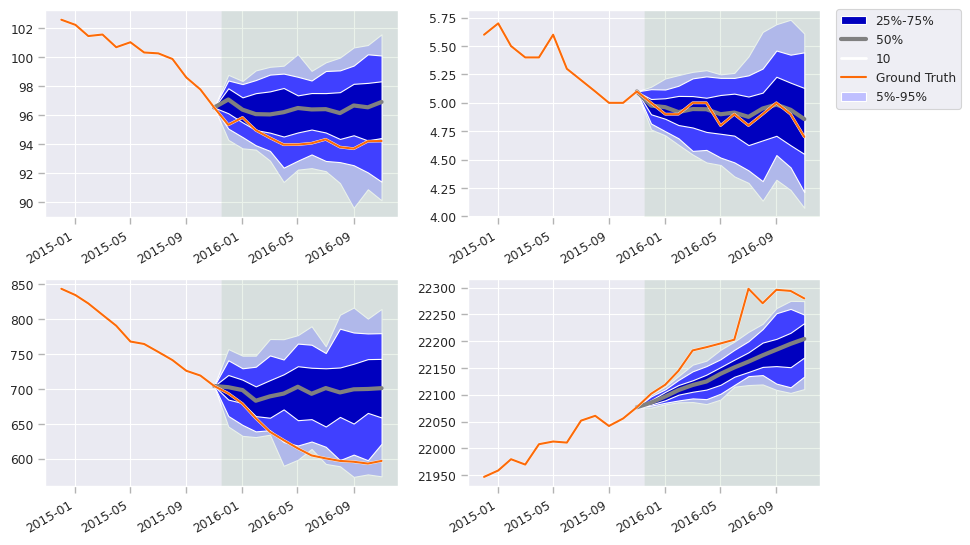

In [18]:
plot_four_forecasts(
    forecasts=forecasts,
    targets=targets,
    selection=[(0, 10), (0, 20), (0, 30), (0, 40)],
    tick_freq="4 months end",
    history_length=estimator.history_length,
)